# **CHAPTER 3. Comparative genomics**

In [ ]:
from pathlib import Path, PosixPath
from pygenomeviz import GenomeViz
from pygenomeviz.parser import Genbank
from pygenomeviz.align import MMseqs
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqFeature import FeatureLocation

First and foremost create a directory to store the data

In [2]:
! mkdir data/

Now, download mitochondrions of 5 fungi in genbank format

First: _Antarctomyces pellizariae_

In [3]:
! esearch -db nucleotide \
    -query 'NC_048507' \
    | efetch -format gb > data/ap.gb

We will also need its mitochondrion in fasta format

In [ ]:
! cp ../01_PanPhylo_analysis/Leotiomycetes/NC_048507.1.fasta data/ap.fasta

Second: _Antarctomyces psychrotrophicus_

In [4]:
! esearch -db nucleotide \
    -query 'NC_082276' \
    | efetch -format gb > data/aps.gb

And its fasta file

In [3]:
! cp ../01_PanPhylo_analysis/Leotiomycetes/NC_082276.1.fasta data/aps.fasta

Third: _Pseudogymnoascus destructans_

In [5]:
! esearch -db nucleotide \
    -query 'NC_033907' \
    | efetch -format gb > data/pd.gb

And its fasta file

In [4]:
! cp ../01_PanPhylo_analysis/Leotiomycetes/NC_033907.1.fasta data/pd.fasta

Fourth: _Pseudogymnoascus pannorum_

In [6]:
! esearch -db nucleotide \
    -query 'NC_027422' \
    | efetch -format gb > data/pp.gb

And its fasta file

In [5]:
! cp ../01_PanPhylo_analysis/Leotiomycetes/NC_027422.1.fasta data/pp.fasta

Finally: _Thelebolus microsporus_

In [7]:
! esearch -db nucleotide \
    -query 'NC_082275' \
    | efetch -format gb > data/tm.gb

And its fasta file

In [6]:
! cp ../01_PanPhylo_analysis/Leotiomycetes/NC_082275.1.fasta data/tm.fasta

Now let's check if everything is good

In [12]:
! ls data/

ap.fasta  aps.fasta pd.fasta  pp.fasta  tm.fasta
ap.gb     aps.gb    pd.gb     pp.gb     tm.gb


Yeah, perfect

## **Part 1. Synteny analysis**

For synteny analysis we will use `.gb` files and `pyGenomeViz` package

First, `pd.gb` file must be anchored to start with `rps3` gene within `rRNA`. It must be done due to circular structure of mitochondrial genome. `pd.gb` must be "aligned" with other genomes in order to provide clear insights.

In [98]:
pd_path = Path("data/pd.gb")
start_pos = 19990  # fixed anchor start (20850 - 860; 860 is where rnl starts in pp.gb)
record = SeqIO.read(pd_path, "genbank")

seq_len = len(record.seq)
new_seq = record.seq[start_pos:] + record.seq[:start_pos]

new_features = []
for f in record.features:
    start = int(f.location.start)
    end = int(f.location.end)
    strand = f.location.strand

    new_start = (start - start_pos) % seq_len
    new_end = (end - start_pos) % seq_len

    if new_start > new_end:
        new_loc = FeatureLocation(new_start, seq_len, strand=strand) + FeatureLocation(0, new_end, strand=strand)
    else:
        new_loc = FeatureLocation(new_start, new_end, strand=strand)

    f.location = new_loc
    new_features.append(f)

record.seq = new_seq
record.features = new_features

output = pd_path.with_name(pd_path.stem + "_rps3anchored.gb")
SeqIO.write(record, output, "genbank")
print(f"Saved reordered file: {output}")

Saved reordered file: data/pd_rps3anchored.gb


Make the order of genomes

In [99]:
# Reordering the list
gbk_files = [
    PosixPath('data/pd_rps3anchored.gb'),
    PosixPath('data/pp.gb'),
    PosixPath('data/tm.gb'),
    PosixPath('data/ap.gb'),
    PosixPath('data/aps.gb')
]

Create the input for `pyGenomeViz`

In [100]:
gbk_list = list(map(Genbank, gbk_files))

Run `pyGenomeViz`!

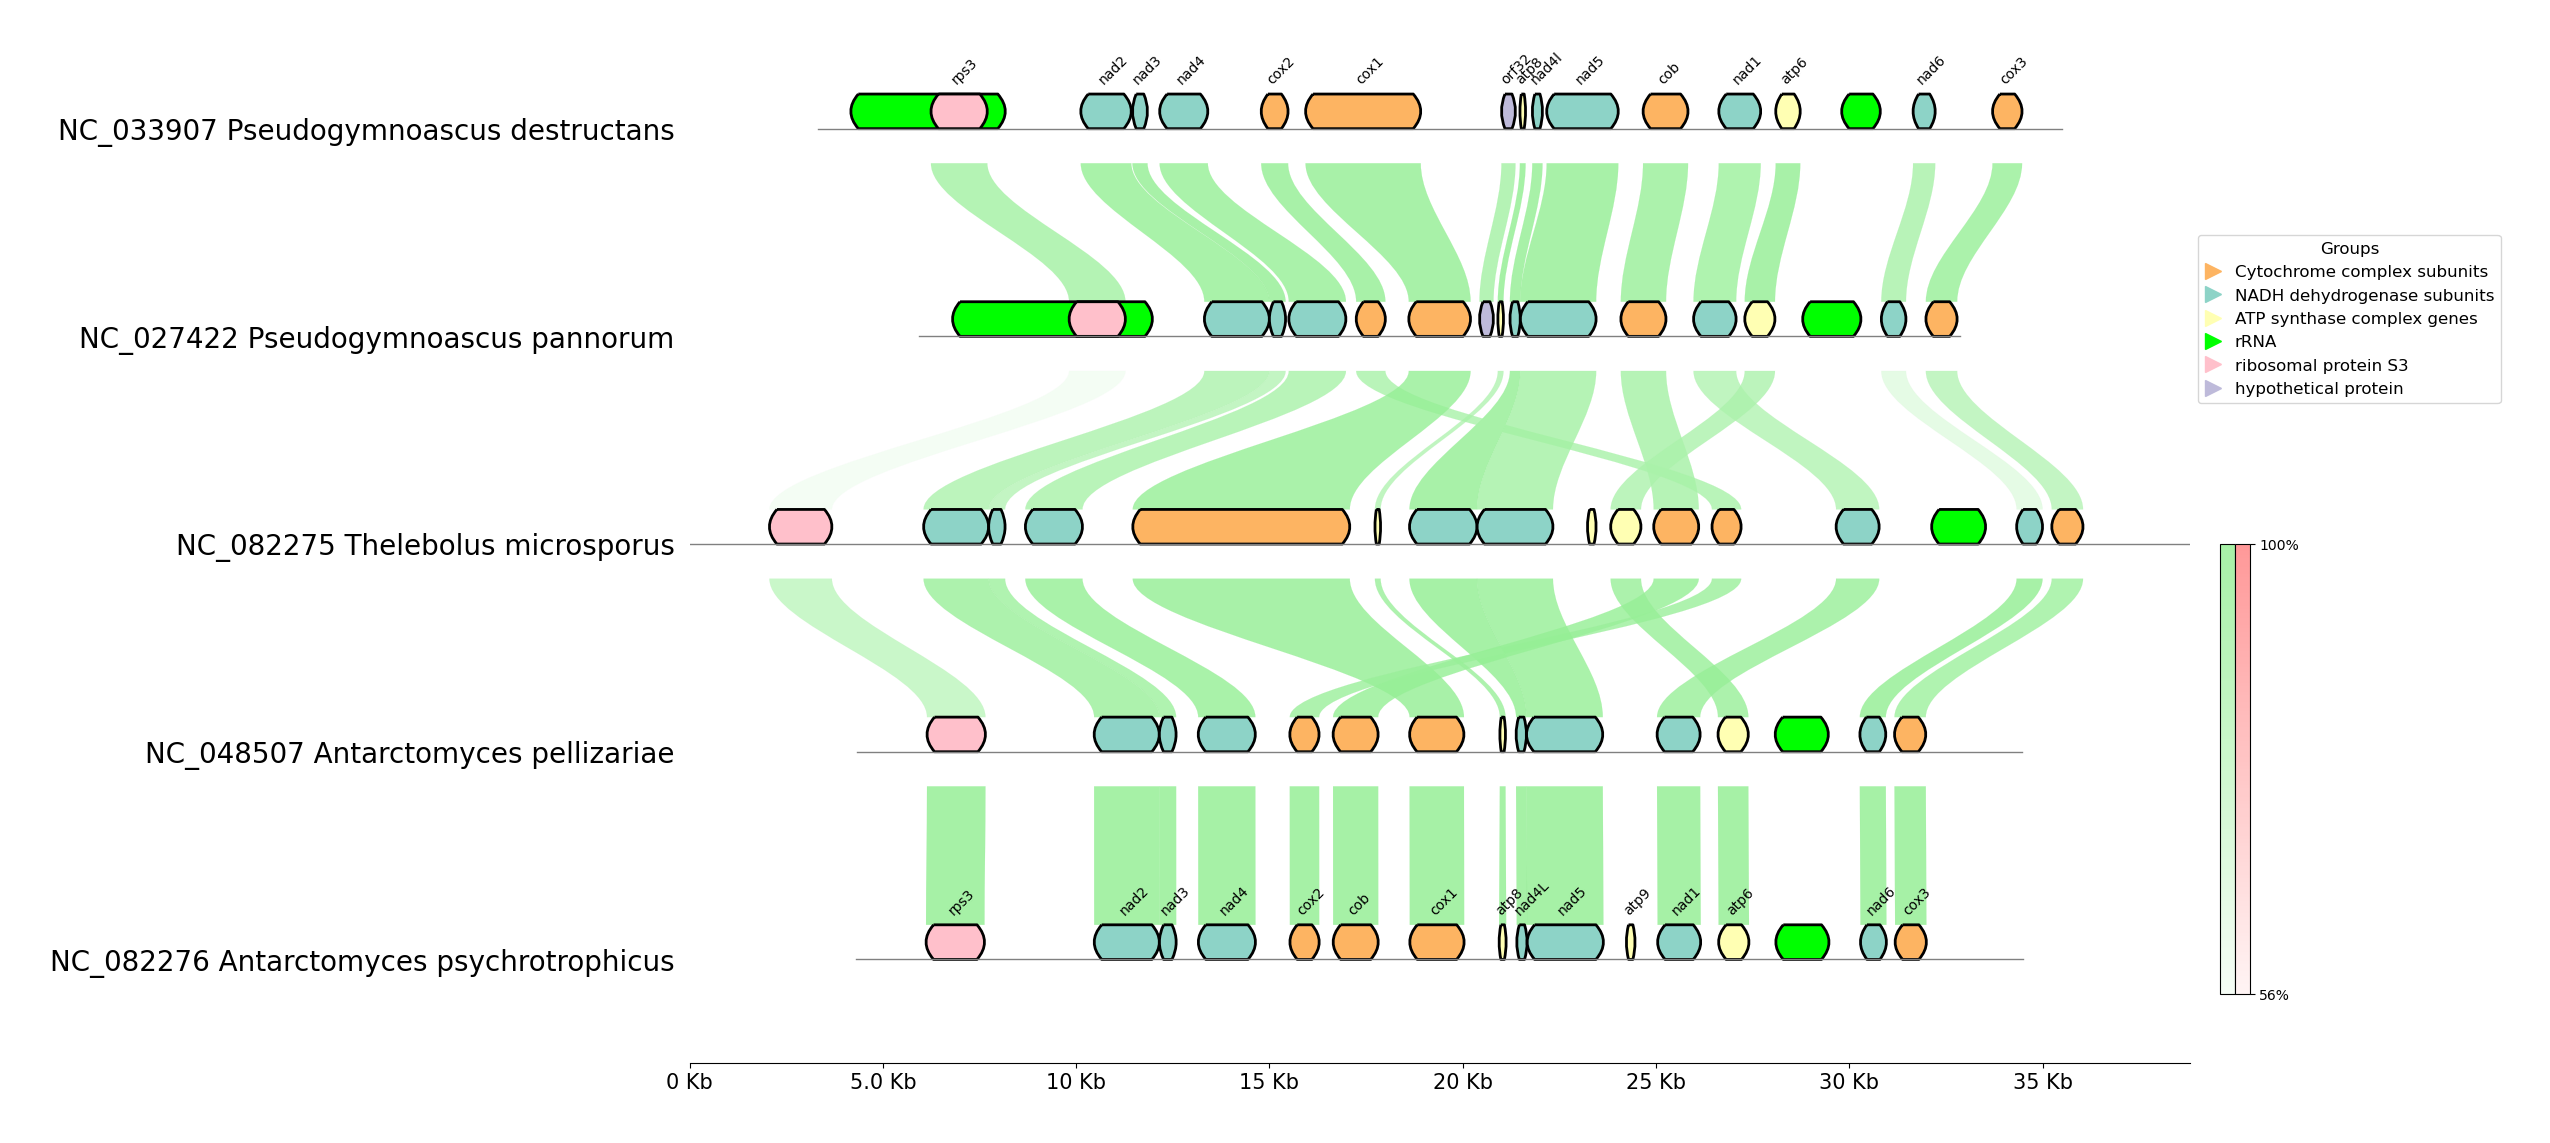

In [104]:
gv = GenomeViz(fig_track_height=1.0, feature_track_ratio=0.5, track_align_type="center")
gv.set_scale_xticks()

# Plot CDS, rRNA features for each contig to tracks
for i, gbk in enumerate(gbk_list):
    track = gv.add_feature_track(gbk.name, gbk.get_seqid2size(), align_label=True)
    if track.name == "pd_rps3anchored":
        track.set_label("NC_033907 Pseudogymnoascus destructans") # or NC_033907 Pseudogymnoascus destructans
    if track.name == "pp":
        track.set_label("NC_027422 Pseudogymnoascus pannorum") # or NC_027422 Pseudogymnoascus pannorum
    if track.name == "tm":
        track.set_label("NC_082275 Thelebolus microsporus") # or NC_082275 Thelebolus microsporus
    if track.name == "ap":
        track.set_label("NC_048507 Antarctomyces pellizariae") # or NC_048507 Antarctomyces pellizariae
    if track.name == "aps":
        track.set_label("NC_082276 Antarctomyces psychrotrophicus") # or NC_082276 Antarctomyces psychrotrophicus
    for seqid, features in gbk.get_seqid2features(None).items():
        segment = track.get_segment(seqid)
        for feature in features:
            if feature.type == "CDS":
                product_name = str(feature.qualifiers.get("product", [""])[0])
                if product_name.lower().startswith("cytochrome") or product_name.lower().startswith("cox") or product_name.lower().startswith("apocytochrome"):
                    fc_color = "#fdb462" #light-orange
                elif product_name.lower().startswith("atp"):
                    fc_color = "#ffffb3" #light-yellow
                elif product_name.lower().startswith("nad"):
                    fc_color = "#8dd3c7" #light-blue
                elif product_name.startswith("ribosomal protein S3"):
                    fc_color = "pink" #pink
                elif product_name.startswith("hypothetical"):
                    fc_color = "#bebada" #light-purple
                else:
                    fc_color = "yellow"  # Default color for other CDS
                
                # Adjust behavior for the first gbk in the list
                if i == 0 or i == 4:  # First gbk in the list
                    segment.add_features(feature, fc=fc_color, plotstyle="rbox", label_type="gene",
                                         text_kws = dict(size=10,
                                                         #rotation=90,
                                                         #vpos="top",
                                                         #hpos="center"
                                                         ),
                                                         lw=2.0)
                else:  # Other gbks
                    segment.add_features(feature, fc=fc_color, plotstyle="rbox", lw=2.0)
            elif feature.type == "rRNA":
                # rRNA: lime
                segment.add_features(feature, fc="lime", plotstyle="rbox", lw=2.0)


# Run MMseqs RBH search
align_coords = MMseqs(gbk_list).run()

# Plot MMseqs alignment links
if len(align_coords) > 0:
    min_ident = int(min([ac.identity for ac in align_coords if ac.identity]))
    color, inverted_color = "#90ee90", "#FF7F7F" #"#90ee90" - light_green, "#FF7F7F" - light_red
    for ac in align_coords:
        gv.add_link(ac.query_link, ac.ref_link, color=color, inverted_color=inverted_color, v=ac.identity, vmin=min_ident, curve=True)
    gv.set_colorbar([color, inverted_color], vmin=min_ident, bar_height = 0.5,)

fig = gv.plotfig()

# Plot legend for groups
_ = fig.legend(
    handles=[
        Line2D([], [], marker=">", color="#fdb462", label="Cytochrome complex subunits", ms=12, ls="none"),
        Line2D([], [], marker=">", color="#8dd3c7", label="NADH dehydrogenase subunits", ms=12, ls="none"),
        Line2D([], [], marker=">", color="#ffffb3", label="ATP synthase complex genes", ms=12, ls="none"),
        Line2D([], [], marker=">", color="lime", label="rRNA", ms=12, ls="none"),
        Line2D([], [], marker=">", color="pink", label="ribosomal protein S3", ms=12, ls="none"),
        Line2D([], [], marker=">", color="#bebada", label="hypothetical protein", ms=12, ls="none"),
    ],
    fontsize=12,
    title="Groups",
    title_fontsize=12,
    loc="center left",
    bbox_to_anchor=(1, 0.75),
    handlelength=1.0,
)

Looking good! Now save the picture

Make a directory to store the images

In [37]:
! mkdir imgs/

Set the size of picture

In [96]:
fig.set_size_inches(14, 8)

Save it!

In [ ]:
fig.savefig("imgs/synteny_plot.png", dpi=600, bbox_inches="tight")

## **Part 2: Average Nucleotide Identity**

Download `.zip` archive with `FastANI`

In [ ]:
! wget https://github.com/ParBLiSS/FastANI/releases/download/v1.34/fastANI-linux64-v1.34.zip

Make a directory where to store all the `ANI` analysis files

In [7]:
! mkdir ANI

Unarchive `FastANI` to `ANI` directory and delete the archive

In [8]:
! unzip fastANI-linux64-v1.34.zip -d ANI && rm -rf fastANI-linux64-v1.34.zip

Archive:  fastANI-linux64-v1.34.zip
  inflating: ANI/fastANI             


Create the input files for `FastANI`

In [15]:
! ls data/*.fasta > ANI/querylist.txt && ls data/*.fasta > ANI/reflist.txt

Run `FastANI`!

In [ ]:
! ANI/fastANI --ql ANI/querylist.txt --rl ANI/reflist.txt -o ANI/fastani.out --matrix

Create a renaming map for good visualization

In [ ]:
# Load the contents of the file
file_path = 'ANI/fastani.out'

with open(file_path, 'r') as file:
    file_content = file.read()

# Define the mapping for renaming the files
rename_map = {
    "data/ap.fasta": "NC_048507 Antarctomyces pellizariae",
    "data/aps.fasta": "NC_082276 Antarctomyces psychrotrophicus",
    "data/pd.fasta": "NC_033907 Pseudogymnoascus destructans",
    "data/pp.fasta": "NC_027422 Pseudogymnoascus pannorum",
    "data/tm.fasta": "NC_082275 Thelebolus microsporus",
}

# Replace the names in the file content
for old_name, new_name in rename_map.items():
    file_content = file_content.replace(old_name, new_name)

# Save the updated content back to the file
with open(file_path, 'w') as file:
    file.write(file_content)

Visualize `FastANI` results as the heatmap!

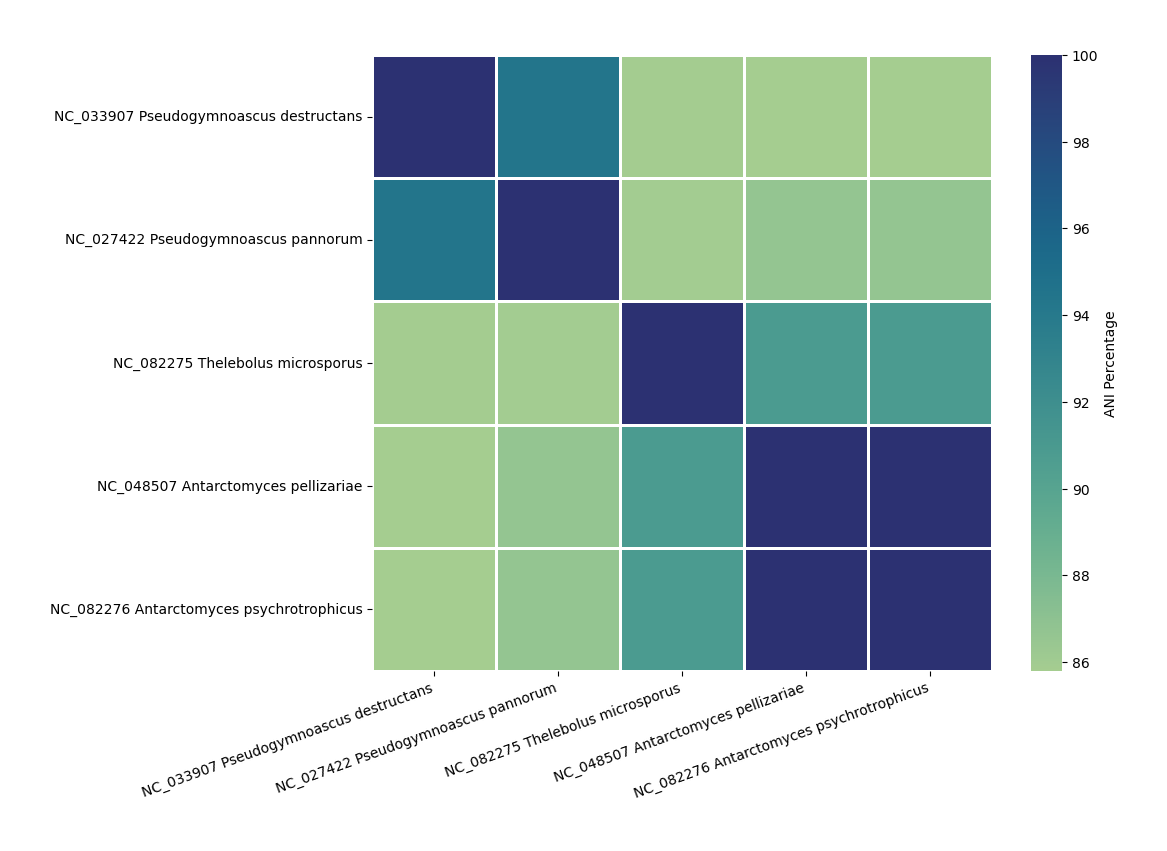

In [ ]:
# Load the FastANI output file
file_path = "ANI/fastani.out"  # Change to your actual path
with open(file_path, 'r') as file:
    content = file.readlines()

# Extracting the necessary data
data = []
for line in content:
    parts = line.strip().split('\t')
    genome1 = parts[0].split('/')[-1]
    genome2 = parts[1].split('/')[-1]
    ani_value = float(parts[2])
    data.append([genome1, genome2, ani_value])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['Genome1', 'Genome2', 'ANI'])

# Create a symmetric ANI matrix by averaging ANI(A, B) and ANI(B, A)
df_reversed = df.rename(columns={'Genome1': 'Genome2', 'Genome2': 'Genome1'})  # Swap columns
df_combined = pd.concat([df, df_reversed])  # Merge original and reversed
df_avg = df_combined.groupby(['Genome1', 'Genome2']).ANI.mean().reset_index()  # Average values

# Define the desired order
genome_order = [
    "NC_033907 Pseudogymnoascus destructans",
    "NC_027422 Pseudogymnoascus pannorum",
    "NC_082275 Thelebolus microsporus",
    "NC_048507 Antarctomyces pellizariae",
    "NC_082276 Antarctomyces psychrotrophicus"
]

# Convert columns to categorical with the specified order
df_avg["Genome1"] = pd.Categorical(df_avg["Genome1"], categories=genome_order, ordered=True)
df_avg["Genome2"] = pd.Categorical(df_avg["Genome2"], categories=genome_order, ordered=True)

# Sort by Genome1 first, then Genome2
df_avg = df_avg.sort_values(by=["Genome1", "Genome2"]).reset_index(drop=True)

# Create a symmetric pivot table
pivot_table = df_avg.pivot(index='Genome1', columns='Genome2', values='ANI')

# Fill diagonal with 100 (since ANI(A, A) is always 100)
#for genome in pivot_table.index:
    #pivot_table.at[genome, genome] = 100

# Sort for better visualization
pivot_table = pivot_table.sort_index(axis=0).sort_index(axis=1)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(pivot_table,
                      annot=False,
                      cmap='crest',
                      cbar_kws={'label': 'ANI Percentage'},
                      vmin=float(df_avg['ANI'].min()),
                      vmax=float(df_avg['ANI'].max()),
                      linewidths=2,  # Adjust line thickness
                      linecolor='white')  # Set outline color)
plt.xticks(rotation=20, ha='right') #, fontsize=12)
#plt.xticks(rotation=90)
plt.yticks(rotation=0) #, fontsize=12)
plt.xlabel(None)
plt.ylabel(None)
plt.savefig('imgs/fastANI_heatmap.png', dpi=600, bbox_inches='tight')

Lifehack for future:<br>
If you want custom color map for seaborn heatmap

1. Go there - https://r-graph-gallery.com/color-palette-finder
2. Copy some color map
3. Import matplotlib.colors

```
import matplotlib.colors as mcolors
```

4. Define  custom color palette

```
custom_colors = ['#FAE9A0', '#DBD797', '#BCC68D', '#9CB484', '#7DA37B', 
                 '#5E9171', '#3F7F68', '#1F6E5E', '#005C55']
```

5. Create a custom colormap

```
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", custom_colors)
```